In [1]:
version = 3.9
name_dataset = f"tlm2ros_train_dataset_v{version}.jsonl"
name_model = f"flan-t5-base_planner_v{version}"

In [2]:
import torch
import json
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from datasets import Dataset
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
import os

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from google.colab import drive
drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


In [3]:
def load_dataset_from_jsonl(file_path):
    """Load dataset from JSONL file"""
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, 1):
                line = line.strip()
                if line:  # Skip empty lines
                    try:
                        data.append(json.loads(line))
                    except json.JSONDecodeError as e:
                        print(f"Warning: Skipping line {line_num} due to JSON error: {e}")
        print(f"Successfully loaded {len(data)} examples from {file_path}")
    except FileNotFoundError:
        print(f"Error: File {file_path} not found!")
        return []
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return []
    return data

def format_training_example(example):
    """Format training example for FLAN-T5 - input already contains full prompt"""
    return {
        "input_text": example['input'],
        "target_text": example['output']
    }

# Load and prepare dataset
print("Loading dataset from test_dataset.jsonl...")
dataset_path = f"/content/drive/MyDrive/colab_notebooks/{name_dataset}"
raw_data = load_dataset_from_jsonl(dataset_path)

if not raw_data:
    print("No data loaded. Please ensure test_dataset.jsonl exists and is properly formatted.")
    exit()

# Format the dataset
formatted_data = [format_training_example(ex) for ex in raw_data]

train_data, val_data = train_test_split(
    formatted_data,
    test_size=0.2,
    random_state=42,  # For reproducibility
    shuffle=True      # Ensure random shuffling
)

# train_data = formatted_data
# val_data = formatted_data

# Create datasets
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)

print(f"Dataset split completed:")
print(f"  Training examples: {len(train_dataset)}")
print(f"  Validation examples: {len(val_dataset)}")
print(f"  Total examples: {len(formatted_data)}")


Loading dataset from test_dataset.jsonl...
Successfully loaded 1700 examples from /content/drive/MyDrive/colab_notebooks/tlm2ros_train_dataset_v3.9.jsonl
Dataset split completed:
  Training examples: 1360
  Validation examples: 340
  Total examples: 1700


In [4]:
print("\n🔍 Dataset sample check:")
print(f"  Sample input: {raw_data[0]['input'][:100]}...")
print(f"  Sample output: {raw_data[0]['output']}")
print(f"  Input length: {len(raw_data[0]['input'])}")
print(f"  Output length: {len(raw_data[0]['output'])}")


🔍 Dataset sample check:
  Sample input: Available missions: skip, goal_NW, goal_NE, goal_SW, goal_SE, survey_NW, survey_NE, survey_SW, surve...
  Sample output: make move B
  Input length: 1276
  Output length: 11


In [5]:
# Load model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Fix tokenizer padding
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded: {model_name}")
print(f"Original model parameters: {model.num_parameters():,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model loaded: google/flan-t5-base
Original model parameters: 247,577,856


In [6]:
# LoRA configuration for T5 - optimized for small model
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  # Rank for LoRA adaptation
    lora_alpha=16,  # LoRA scaling parameter
    lora_dropout=0.1,
    # Target modules for T5 architecture
    target_modules=["q", "v", "k", "o", "wi", "wo"],
    bias="none",  # Don't adapt biases
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 2,310,144 || all params: 249,888,000 || trainable%: 0.9245


In [7]:
def preprocess_function(examples):
    """Tokenize input and target for T5"""
    inputs = examples["input_text"]
    targets = examples["target_text"]

    # Tokenize input
    model_inputs = tokenizer(
        inputs,
        max_length=256,
        truncation=True,
        padding=True,  # Use dynamic padding
        return_tensors="pt" if isinstance(inputs, str) else None
    )

    # Tokenize target (labels)
    labels = tokenizer(
        text_target=targets,
        max_length=32,
        truncation=True,
        padding=True,  # Use dynamic padding
        return_tensors="pt" if isinstance(targets, str) else None
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply tokenization to both datasets
print("Tokenizing training dataset...")
tokenized_train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

print("Tokenizing validation dataset...")
tokenized_val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names
)

print("Tokenization completed!")

Tokenizing training dataset...


Map:   0%|          | 0/1360 [00:00<?, ? examples/s]

Tokenizing validation dataset...


Map:   0%|          | 0/340 [00:00<?, ? examples/s]

Tokenization completed!


In [8]:
class CustomTrainer(Trainer):
    """Optimized custom trainer with enhanced tracking, early stopping, and plotting"""

    def __init__(self, *args, save_logs=True, **kwargs):
        super().__init__(*args, **kwargs)

        # Efficient tracking with defaultdict
        self.metrics_history = defaultdict(list)
        self._eval_steps = []  # Track evaluation steps separately

        # Logging configuration
        self.save_logs = save_logs
        self.log_file = os.path.join(self.args.output_dir, "training_logs.json") if save_logs else None

        # Performance optimization
        self._last_logged_step = -1
        self._current_train_loss = None  # Track current training loss


    def log(self, logs, start_time=None):
        super().log(logs, start_time)

        current_step = self.state.global_step

        # Avoid duplicate logging for same step
        if current_step == self._last_logged_step:
            return
        self._last_logged_step = current_step

        # Only store metrics when we have evaluation data (end of epoch)
        if "eval_loss" in logs:
            # Store all numeric metrics
            for key, value in logs.items():
                if isinstance(value, (int, float)):
                    self.metrics_history[key].append(value)

            self._eval_steps.append(current_step)
            # self._check_early_stopping(logs["eval_loss"], current_step)

        # Enhanced progress reporting
        if "eval_loss" in logs or "train_loss" in logs:
            self._print_progress(logs, current_step)

        # Save logs periodically
        if self.save_logs and "eval_loss" in logs:
            self._save_logs()

    def _print_progress(self, logs, step):
        """Clean progress printing with key metrics, including custom metrics"""
        metrics = []

        if "train_loss" in logs:
            metrics.append(f"Train: {logs['train_loss']:.4f}")
        if "eval_loss" in logs:
            metrics.append(f"Val: {logs['eval_loss']:.4f}")
        if "token_accuracy" in logs:
            metrics.append(f"TokenAcc: {logs['token_accuracy']:.4f}")
        if "sequence_accuracy" in logs:
            metrics.append(f"SeqAcc: {logs['sequence_accuracy']:.4f}")

        # Fetch current learning rate from optimizer
        lr = None
        if hasattr(self, 'optimizer') and self.optimizer is not None:
            lr = self.optimizer.param_groups[0]['lr']
            metrics.append(f"LR: {lr:.2e}")

        epoch = getattr(self.state, 'epoch', 0)
        print(f"[Epoch {epoch:.1f} | Step {step}] {' | '.join(metrics)}")


    def _save_logs(self):
        """Save comprehensive training logs"""
        if not self.log_file:
            return
        try:
            os.makedirs(os.path.dirname(self.log_file), exist_ok=True)
            logs_data = {
                'metrics': dict(self.metrics_history),
                'eval_steps': self._eval_steps,
            }
            with open(self.log_file, 'w') as f:
                json.dump(logs_data, f, indent=2)
        except Exception as e:
            print(f"Warning: Could not save logs: {e}")

    def training_step(self, model, inputs, optimizer=None):
        # Ensure all inputs are on the correct device
        inputs = self._prepare_inputs(inputs)
        return super().training_step(model, inputs, optimizer)


    def plot_losses(self, figsize=(12, 8), save_path=None):
        """Plot training/validation loss, LR schedule, token/sequence accuracy"""

        if not hasattr(self.state, "log_history") or len(self.state.log_history) == 0:
            print("No log history to plot yet.")
            return

        # Collect data from log_history
        steps, train_loss, eval_loss = [], [], []
        lr, token_acc, seq_acc = [], [], []

        for entry in self.state.log_history:
            step = entry.get("step")
            if step is None:
                continue

            if "loss" in entry:  # training loss
                steps.append(step)
                train_loss.append(entry["loss"])
            if "eval_loss" in entry:  # validation loss
                eval_loss.append((step, entry["eval_loss"]))
            if "learning_rate" in entry:
                lr.append((step, entry["learning_rate"]))
            if "eval_token_accuracy" in entry or "token_accuracy" in entry:
                key = "eval_token_accuracy" if "eval_token_accuracy" in entry else "token_accuracy"
                token_acc.append((step, entry[key]))
            if "eval_sequence_accuracy" in entry or "sequence_accuracy" in entry:
                key = "eval_sequence_accuracy" if "eval_sequence_accuracy" in entry else "sequence_accuracy"
                seq_acc.append((step, entry[key]))

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()

        # 1. Training vs Validation Loss
        ax1 = axes[0]
        if steps and train_loss:
            ax1.plot(steps[:len(train_loss)], train_loss, label="Training Loss", color="blue", linewidth=2)
        if eval_loss:
            eval_x, eval_y = zip(*eval_loss)
            ax1.plot(eval_x, eval_y, label="Validation Loss", color="red", marker="o", linewidth=2)
        ax1.set_xlabel("Steps")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training vs Validation Loss")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Learning Rate
        ax2 = axes[1]
        if lr:
            lr_x, lr_y = zip(*lr)
            ax2.plot(lr_x, lr_y, label="Learning Rate", color="green", linewidth=2)
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("Learning Rate")
        ax2.set_title("Learning Rate Schedule")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Token Accuracy
        ax3 = axes[2]
        if token_acc:
            tok_x, tok_y = zip(*token_acc)
            ax3.plot(tok_x, tok_y, label="Token Accuracy", color="purple", marker="o", linewidth=2)
        else:
            ax3.text(0.5, 0.5, "Token Accuracy\nNot Available",
                    ha="center", va="center", transform=ax3.transAxes, fontsize=12)
        ax3.set_xlabel("Steps")
        ax3.set_ylabel("Accuracy")
        ax3.set_title("Token Accuracy")
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Sequence Accuracy
        ax4 = axes[3]
        if seq_acc:
            seq_x, seq_y = zip(*seq_acc)
            ax4.plot(seq_x, seq_y, label="Sequence Accuracy", color="orange", marker="o", linewidth=2)
        else:
            ax4.text(0.5, 0.5, "Sequence Accuracy\nNot Available",
                    ha="center", va="center", transform=ax4.transAxes, fontsize=12)
        ax4.set_xlabel("Steps")
        ax4.set_ylabel("Accuracy")
        ax4.set_title("Sequence Accuracy")
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"📊 Plot saved to {save_path}")
        plt.show()


    def get_training_summary(self):
        """Get comprehensive training summary"""
        if not self.metrics_history:
            return "No training data available."


        summary = {
            'total_steps': max(self._eval_steps) if self._eval_steps else 0,
            'total_epochs': getattr(self.state, 'epoch', 0),
            'final_train_loss': self.metrics_history.get("train_loss", [None])[-1],
            'final_val_loss': self.metrics_history.get("eval_loss", [None])[-1],
        }


        print("\n📈 Training Summary:")
        print(f"  Total steps: {summary['total_steps']}")
        print(f"  Total epochs: {summary['total_epochs']:.1f}")
        print(f"  Final train loss: {summary['final_train_loss']:.4f}" if summary['final_train_loss'] else "  Final train loss: N/A")
        print(f"  Final val loss: {summary['final_val_loss']:.4f}" if summary['final_val_loss'] else "  Final val loss: N/A")
        # print(f"  Best val loss: {summary['best_val_loss']:.4f} (step {summary['best_step']})" if summary['best_val_loss'] else "  Best val loss: N/A")
        # print(f"  Early stopped: {'Yes' if summary['early_stopped'] else 'No'}")

        return summary


# Custom learning rate scheduler function for FLAN-T5
def get_polynomial_decay_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, lr_end=1e-7, power=1.0):
    """Polynomial decay schedule with warmup - optimal for FLAN-T5"""
    from transformers.optimization import get_polynomial_decay_schedule_with_warmup
    return get_polynomial_decay_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        lr_end=lr_end,
        power=power
    )

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # HuggingFace Seq2SeqTrainer a volte restituisce tuple (logits, ...)
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Prendi l’ID del token più probabile
    preds = np.argmax(predictions, axis=-1)

    # Mask per ignorare i token speciali (-100 usato dal trainer)
    label_mask = labels != -100

    # ---- Token accuracy ----
    token_correct = (preds == labels) & label_mask
    token_accuracy = token_correct.sum() / label_mask.sum()

    # ---- Sequence accuracy ----
    seq_correct = []
    for pred, label in zip(preds, labels):
        # Togli padding e token ignorati
        l = [t for t in label if t not in [-100, 0]]
        p = [t for t in pred[:len(l)] if t not in [0]]

        # Sequenza giusta solo se TUTTI i token combaciano
        seq_correct.append(p == l)

    seq_accuracy = np.mean(seq_correct)

    return {
        "token_accuracy": float(token_accuracy),
        "sequence_accuracy": float(seq_accuracy),
    }


In [10]:
num_epochs = 7
batch_size = 8
gradient_accumulation_steps = 2
learning_rate = 3e-4

total_steps = (len(tokenized_train_dataset) // (batch_size * gradient_accumulation_steps)) * num_epochs
warmup_steps = max(30, int(0.05 * total_steps))  # at leat 30 warmup steps

training_args = TrainingArguments(
    output_dir="./flan-t5-lora-sequence-planner",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=16,

    learning_rate=learning_rate,
    lr_scheduler_type="linear",
    warmup_steps=warmup_steps,

    eval_strategy="epoch",
    logging_steps=(len(tokenized_train_dataset) // (batch_size * gradient_accumulation_steps)),

    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="sequence_accuracy",
    greater_is_better=True,
    save_total_limit=2,

    weight_decay=0.01,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,

    dataloader_pin_memory=False,
    gradient_checkpointing=False,
    # fp16=torch.cuda.is_available(),
    fp16=False,
    remove_unused_columns=False,
    dataloader_num_workers=2,

    report_to=None,
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.005
)


print(f"📊 Training configuration:")
print(f"  Dataset size: {len(tokenized_train_dataset)} train, {len(tokenized_val_dataset)} val")
print(f"  Total training steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")

# Data collator with optimizations
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    return_tensors="pt",
    pad_to_multiple_of=8 if training_args.fp16 else None,
)

print("✅ Training configuration completed!")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 Training configuration:
  Dataset size: 1360 train, 340 val
  Total training steps: 595
  Warmup steps: 30
  Epochs: 7
  Batch size: 8
  Learning rate: 0.0003
✅ Training configuration completed!


🚀 Starting training...
  Training examples: 1360
  Validation examples: 340


Epoch,Training Loss,Validation Loss,Token Accuracy,Sequence Accuracy
1,8.547600,1.765401,0.586765,0.258824
2,1.243300,0.275431,0.949510,0.697059
3,0.364200,0.102800,0.967647,0.805882
4,0.171500,0.037172,0.989216,0.935294
5,0.116900,0.021424,0.996078,0.976471
6,0.093500,0.021707,0.995588,0.973529
7,0.082800,0.018475,0.995588,0.973529



🎉 Training completed successfully!
📊 Plot saved to ./flan-t5-lora-sequence-planner/training_curves.png


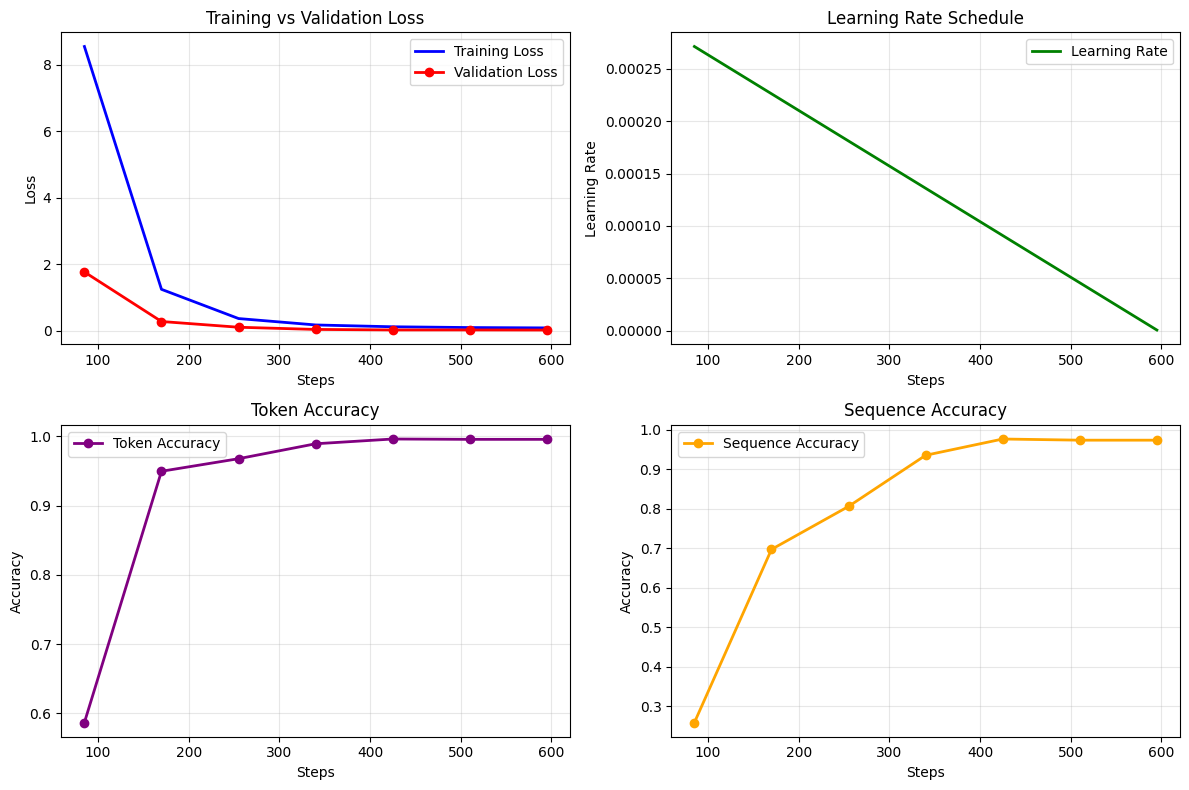

In [11]:
# Initialize optimized custom trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    processing_class=tokenizer,
    data_collator=data_collator,
    save_logs=True                 # Enable log saving
)

print("🚀 Starting training...")
print(f"  Training examples: {len(tokenized_train_dataset)}")
print(f"  Validation examples: {len(tokenized_val_dataset)}")

# Train the model with comprehensive tracking
try:
    trainer.train()
    print("\n🎉 Training completed successfully!")

    # Get and display training summary
    summary = trainer.get_training_summary()

    # Plot results
    trainer.plot_losses(save_path=f"{training_args.output_dir}/training_curves.png")

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user")
    if trainer.metrics_history:
        trainer.plot_losses()
        trainer.get_training_summary()

except Exception as e:
    print(f"\n❌ Training failed: {e}")
    if trainer.metrics_history:
        print("Plotting available data...")
        trainer.plot_losses()


In [12]:
def analyze_training_results(trainer):
    """Analyze training results and provide insights from log_history"""

    if not hasattr(trainer.state, "log_history") or len(trainer.state.log_history) == 0:
        print("No training data to analyze.")
        return

    print("\n🔍 Training Analysis:")

    # --- Collect metrics from log_history ---
    eval_loss, train_loss, lr, token_acc, seq_acc = [], [], [], [], []
    for entry in trainer.state.log_history:
        if "eval_loss" in entry:
            eval_loss.append(entry["eval_loss"])
        if "loss" in entry:
            train_loss.append(entry["loss"])
        if "learning_rate" in entry:
            lr.append(entry["learning_rate"])
        if "eval_token_accuracy" in entry or "token_accuracy" in entry:
            key = "eval_token_accuracy" if "eval_token_accuracy" in entry else "token_accuracy"
            token_acc.append(entry[key])
        if "eval_sequence_accuracy" in entry or "sequence_accuracy" in entry:
            key = "eval_sequence_accuracy" if "eval_sequence_accuracy" in entry else "sequence_accuracy"
            seq_acc.append(entry[key])

    # --- Loss analysis ---
    if eval_loss:
        min_loss = min(eval_loss)
        min_epoch = eval_loss.index(min_loss) + 1
        print(f"  Best validation loss: {min_loss:.6f} (epoch {min_epoch})")

        if len(eval_loss) > 3:
            recent = eval_loss[-3:]
            if all(recent[i] >= recent[i-1] for i in range(1, len(recent))):
                print("  ⚠️ Possible overfitting: validation loss rising in last epochs")

    if train_loss:
        if len(train_loss) >= 5:
            recent = train_loss[-5:]
            if np.std(recent) < 0.01:
                print("  ✅ Training loss has converged (low variance)")
            else:
                print(f"  📈 Training loss still varying (std: {np.std(recent):.4f})")

        if eval_loss:
            gap = eval_loss[-1] - train_loss[-1]
            if gap > 0.1:
                print(f"  ⚠️ Large train-val gap: {gap:.4f} (possible overfitting)")
            elif gap < 0.02:
                print(f"  ✅ Good train-val alignment: {gap:.4f}")
            else:
                print(f"  📊 Train-val gap: {gap:.4f}")

    # --- Learning rate ---
    if lr:
        decay_ratio = lr[-1] / lr[0] if lr[0] > 0 else 0
        print(f"  Learning rate decay: {decay_ratio:.3f}x (final: {lr[-1]:.2e})")

    # --- Token accuracy ---
    if token_acc:
        final, best, initial = token_acc[-1], max(token_acc), token_acc[0]
        print(f"  Token accuracy: {final:.4f} (best: {best:.4f})")
        if final - initial > 0.01:
            print(f"    📈 Improved by {final - initial:.4f}")
        elif final - initial < -0.01:
            print(f"    📉 Dropped by {abs(final - initial):.4f}")
        if len(token_acc) > 3:
            recent = token_acc[-3:]
            if all(recent[i] >= recent[i-1] for i in range(1, len(recent))):
                print("    ✅ Token accuracy still improving")
            elif all(recent[i] <= recent[i-1] for i in range(1, len(recent))):
                print("    ⚠️ Token accuracy declining")

    # --- Sequence accuracy ---
    if seq_acc:
        final, best, initial = seq_acc[-1], max(seq_acc), seq_acc[0]
        print(f"  Sequence accuracy: {final:.4f} (best: {best:.4f})")
        if final - initial > 0.01:
            print(f"    📈 Improved by {final - initial:.4f}")
        elif final - initial < -0.01:
            print(f"    📉 Dropped by {abs(final - initial):.4f}")
        if len(seq_acc) > 3:
            recent = seq_acc[-3:]
            if all(recent[i] >= recent[i-1] for i in range(1, len(recent))):
                print("    ✅ Sequence accuracy still improving")
            elif all(recent[i] <= recent[i-1] for i in range(1, len(recent))):
                print("    ⚠️ Sequence accuracy declining")

    # --- Compare token vs sequence accuracy ---
    if token_acc and seq_acc:
        if token_acc[-1] > 0.9 and seq_acc[-1] < 0.5:
            print("  💡 High token accuracy but low sequence accuracy – model struggles with full sequences")
        elif token_acc[-1] > 0.8 and seq_acc[-1] > 0.7:
            print("  🎯 Good performance on both token and sequence level")

    # --- Training efficiency ---
    if eval_loss:
        print(f"  Training completed: {len(eval_loss)} eval checkpoints")
        if len(eval_loss) > 1:
            improvement = eval_loss[0] - eval_loss[-1]
            pct = (improvement / eval_loss[0]) * 100
            if improvement > 0:
                print(f"  📈 Validation loss improved by {improvement:.4f} ({pct:.1f}%)")
            else:
                print(f"  📉 Validation loss worsened by {abs(improvement):.4f} ({abs(pct):.1f}%)")

analyze_training_results(trainer)


🔍 Training Analysis:
  Best validation loss: 0.018475 (epoch 7)
  📈 Training loss still varying (std: 0.1038)
  ✅ Good train-val alignment: -0.0643
  Learning rate decay: 0.002x (final: 5.31e-07)
  Token accuracy: 0.9956 (best: 0.9961)
    📈 Improved by 0.4088
    ⚠️ Token accuracy declining
  Sequence accuracy: 0.9735 (best: 0.9765)
    📈 Improved by 0.7147
    ⚠️ Sequence accuracy declining
  🎯 Good performance on both token and sequence level
  Training completed: 7 eval checkpoints
  📈 Validation loss improved by 1.7469 (99.0%)


In [13]:
# Save the trained LoRA adapter
save_path = f"/content/drive/MyDrive/colab_notebooks/{name_model}"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to: {save_path}")

Model and tokenizer saved to: /content/drive/MyDrive/colab_notebooks/flan-t5-base_planner_v3.9
